In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd 
from sklearn.metrics import mean_squared_error as mse
from unidecode import unidecode

### 1. Read historical wheat data 
- for Argentina on municipality level
- from 1969-2022
- SOURCE: https://datosestimaciones.magyp.gob.ar/

In [10]:
df = (pd
      .read_csv("files/crop data/historical_wheat_data_argentina.csv", encoding="latin-1", sep=";")
      .drop(columns={"Cultivo", "idProvincia", "idDepartamento", "Sup. Sembrada"}))

df.columns = ["year", "province", "municipality", "harvested area [ha]", "production [t]", "yield [kg/ha]"]

"""
"Campaña" (campaign or season) is based on USDA marketing year defintion. Argentinian wheat season spans from June-Dec. 
The following paragraph from USDA from April 2023 indicates how the first year number (e.g. XXXX in XXXX/YY) is relevant for our crop forecasts.

Post estimates Argentine wheat production to rebound to 19.5 million metric tons (MMT) in marketing year (MY) 2023/24, 
resulting in wheat exports of 13.7 MMT (including wheat flour as its wheat equivalent). However after the severe drought in MY 2022/23, 
more rains are needed to recharge soil moisture profiles before the June planting window (from: https://www.fas.usda.gov/data/argentina-grain-and-feed-annual-9)
"""
df["year"] = df["year"].str[:4].astype(int)

df.head()

,year,province,municipality,harvested area [ha],production [t],yield [kg/ha]
0,1969,BUENOS AIRES,25 DE MAYO,42000,71400,1700
1,1970,BUENOS AIRES,25 DE MAYO,36000,54000,1500
2,1971,BUENOS AIRES,25 DE MAYO,30000,39000,1300
3,1972,BUENOS AIRES,25 DE MAYO,41000,73600,1795
4,1973,BUENOS AIRES,25 DE MAYO,6000,9000,1500


### 2. Filter relevant provinces

In [11]:
production_by_province = df.groupby("province")["production [t]"].sum().reset_index().sort_values(by="production [t]", ascending=False).reset_index(drop=True)
production_by_province["production cumsum [%]"] = np.round(100 * production_by_province["production [t]"] / df["production [t]"].sum()).cumsum()
production_by_province.head()

,province,production [t],production cumsum [%]
0,BUENOS AIRES,359294370,58.0
1,SANTA FE,99172351,74.0
2,CORDOBA,82460626,87.0
3,LA PAMPA,32333143,92.0
4,ENTRE RIOS,28815350,97.0


Buenos Aires, Santa Fe, Cordoba, Entre Rios, and La Pampa contribute most of Argentinian wheat production. 

We will only focus on these 5 provinces from now on. 

In [6]:
df = df.loc[df["province"].isin(['BUENOS AIRES', 'CORDOBA', 'ENTRE RIOS', 'LA PAMPA', 'SANTA FE'])].reset_index(drop=True)

Filter by municipalities with complete time series

In [7]:
df = (df
      [df.groupby(["province", "municipality"])[['province', "municipality"]].transform('size') == len(df["year"].unique().tolist())]
        .reset_index(drop=True))

### 3.  Preprocess

Preprocessing for original (subnational) wheat yield series

In [8]:
df_subnational = df.copy()
df_subnational["province"] = df_subnational["province"].str.lower().apply(lambda x: unidecode(x))
df_subnational["municipality"] = df_subnational["municipality"].str.lower().apply(lambda x: unidecode(x))
df_subnational["name"] = df_subnational["province"] + " " + df_subnational["municipality"]
df_subnational = df_subnational[["year", "name", "harvested area [ha]", "yield [kg/ha]"]]

df_subnational.head()

,year,name,harvested area [ha],yield [kg/ha]
0,1969,buenos aires 25 de mayo,42000,1700
1,1970,buenos aires 25 de mayo,36000,1500
2,1971,buenos aires 25 de mayo,30000,1300
3,1972,buenos aires 25 de mayo,41000,1795
4,1973,buenos aires 25 de mayo,6000,1500


Aggregation to national level by year, where municipality yield is weighted with harvested area from the municipality.

In [9]:
df_national = df.copy()
df_national["yield weighted"] = df_national["yield [kg/ha]"] * df["harvested area [ha]"]
df_national = df_national.groupby("year").agg({"harvested area [ha]":"sum", "yield weighted":"sum"})
df_national["yield [kg/ha]"] = df_national["yield weighted"] / df_national["harvested area [ha]"]
df_national = df_national[["harvested area [ha]", "yield [kg/ha]"]].reset_index()

df_national.head()

,year,harvested area [ha],yield [kg/ha]
0,1969,5058530,1361.123558
1,1970,3553500,1331.921649
2,1971,4171350,1266.672348
3,1972,4819200,1607.983856
4,1973,3824040,1666.552307


### 4. Export 

In [11]:
df_national.to_csv("files/crop data/national_yield_with_trend.csv", index=False)
df_subnational.to_csv("files/crop data/subnational_yield_with_trend.csv", index=False)

### 5. Detrend national data

Compute trend

In [12]:
# dictionary that stores for each year the slope and bias estimated from the previous years
years_to_params = {}
for year in list(range(1993,2023)):
    years_to_params[year] = {"slope":np.nan, "bias":np.nan}
    # from the wheat dataset get the 23 preceding years to the current year, e.g. for year 1993, get 1969-1992
    year_range = df_national.loc[df_national["year"].isin(list(range(year-23, year))), ["year", "yield [kg/ha]"]]
    # estimate slope and bias of a linear fit through these preceding years and store them in dictionary
    slope, bias = np.polyfit(year_range["year"], year_range["yield [kg/ha]"], deg=1)
    years_to_params[year]["slope"] = slope
    years_to_params[year]["bias"] = bias
years_to_params[1993]

{'slope': 32.80242571737997, 'bias': -63239.17143241746}

Filter wheat dataset to study period 1993-2016

In [13]:
df_national_detrended = df_national.loc[df_national["year"].between(1993, 2023)].reset_index(drop=True)

Read shapefiles to create figure for introduction

In [15]:
# read subnational wheat series and store unique region names
relevant_areas = df_subnational["name"].unique()

# Read ADM2 shapefiles (municipality level) and filter by relevant states
gdf_adm2 = gpd.read_file("files/shapefiles/arg_admbnda_adm2_unhcr2017.shp")
gdf_adm2["ADM2_ES"] = gdf_adm2["ADM2_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["ADM1_ES"] = gdf_adm2["ADM1_ES"].str.lower().apply(lambda x: unidecode(x))
gdf_adm2["name"] = gdf_adm2["ADM1_ES"] + " " + gdf_adm2["ADM2_ES"]

# filter areas 
gdf_adm2 = gdf_adm2.loc[gdf_adm2["name"].isin(relevant_areas), ["name", "geometry"]].reset_index(drop=True)

Apply detrending with dictionary and plot figure

372.6


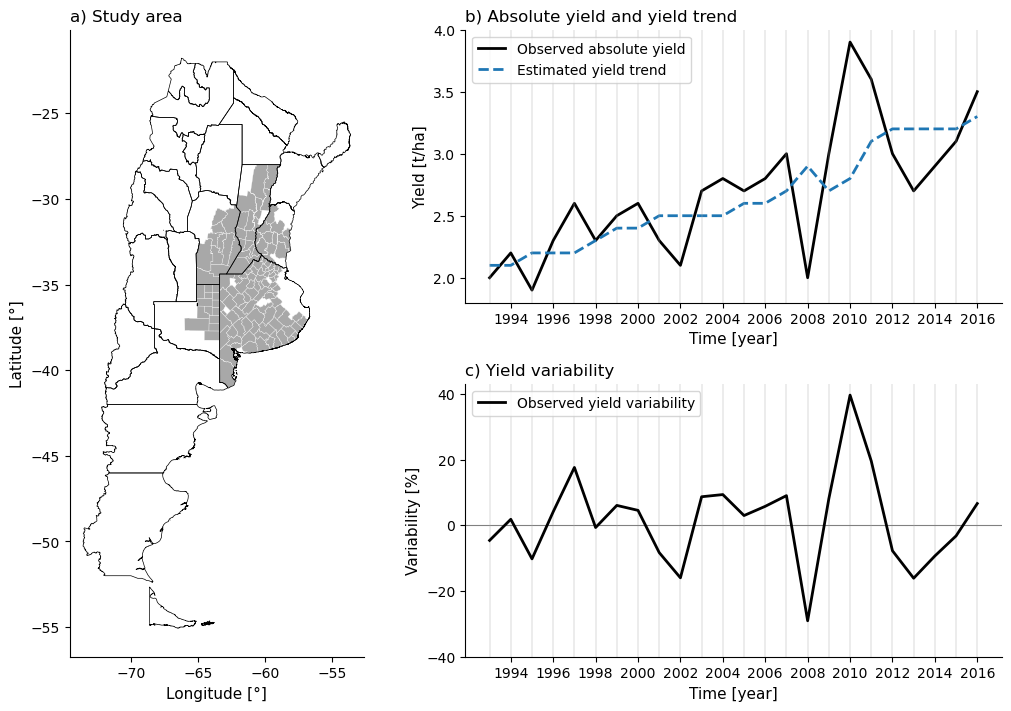

In [17]:
# Create subplots
fig, axd = plt.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']],
                              figsize=(10, 7), layout="constrained", width_ratios=[0.4, 0.6])

# Figure a) Study region
gdf_adm1 = gpd.read_file("files/shapefiles/arg_admbnda_adm1_unhcr2017.shp").to_crs("EPSG:4326")
gdf_adm2.plot(ax=axd["left"], color="#A8A8A8", edgecolor="white", linewidth=.2)
gdf_adm1.plot(ax=axd["left"], color="#FF000000", edgecolor="black", linewidth=0.5)
axd['left'].set_title("a) Study area", loc="left", size=12);
axd['left'].set_ylabel("Latitude [°]", size=11);
axd['left'].set_xlabel("Longitude [°]", size=11);
axd['left'].spines[['right', 'top']].set_visible(False)

# Preprocessing for trend plot
trend_estimated = []
relevant_years = list(range(1993, 2022))
for year in relevant_years:
    value = year * years_to_params[year]["slope"] + years_to_params[year]["bias"]
    trend_estimated.append(value)

# Figure b) Absolute yield and trend
trend_estimates_t_ha = [np.round(x/1000, 1) for x in trend_estimated]
absolute_yield_t_ha = [np.round(x/1000, 1) for x in df_national_detrended["yield [kg/ha]"].values.tolist()]
axd['upper right'].plot(relevant_years[:-5], absolute_yield_t_ha[:-5], label="Observed absolute yield", color="black", linewidth=2)
axd['upper right'].plot(relevant_years[:-5], trend_estimates_t_ha[:-5], label="Estimated yield trend", linewidth=2, linestyle="dashed")
axd['upper right'].set_title("b) Absolute yield and yield trend", loc="left", size=12)
axd['upper right'].set_ylabel("Yield [t/ha]", size=11)
axd['upper right'].set_xlabel("Time [year]", size=11)
axd['upper right'].set_xticks(list(range(1994, 2017, 2)))
xcoords = list(range(1993, 2016, 2))
for xc in xcoords:
    axd['upper right'].axvline(x=xc, linewidth=.3, color="#A8A8A8")
axd['upper right'].grid(axis="x", linewidth=.3, color="#A8A8A8")
axd['upper right'].set_yticks([4, 3.5, 3, 2.5, 2])
axd['upper right'].spines[['right', 'top']].set_visible(False)
axd['upper right'].legend()

# print RMSE of trend estimation
print(np.round(mse(trend_estimated, df_national_detrended["yield [kg/ha]"].values.tolist(), squared=False), 2))

# Detrending
df_national_detrended["yield_trend [kg/ha]"] = trend_estimated
df_national_detrended["yield anomaly [%]"] = (df_national_detrended["yield [kg/ha]"] - df_national_detrended["yield_trend [kg/ha]"]) / df_national_detrended["yield_trend [kg/ha]"]

# Figure c) Detrended yield
axd['lower right'].axhline(0, 0, color="grey", linewidth=.8)
xcoords = list(range(1993, 2016, 2))
for xc in xcoords:
    axd['lower right'].axvline(x=xc, linewidth=.3, color="#A8A8A8")
axd['lower right'].plot(df_national_detrended["year"][:-5], 100 * df_national_detrended["yield anomaly [%]"][:-5], color="black", linewidth=2, label="Observed yield variability")
axd['lower right'].set_title("c) Yield variability", loc="left", size=12)
axd['lower right'].set_ylabel("Variability [%]", size=11)
axd['lower right'].set_xlabel("Time [year]", size=11)
axd['lower right'].set_xticks(list(range(1994, 2017, 2)))
axd['lower right'].grid(axis="x", linewidth=.3, color="#A8A8A8")
axd['lower right'].set_yticks([40, 20, 0, -20, -40])
axd['lower right'].spines[['right', 'top']].set_visible(False)
axd['lower right'].legend(loc="upper left")

#plt.savefig("figures/figure1.svg")

### 6. Export detrended yield dataset

In [18]:
df_national_detrended.to_csv("data/crop/national_yield_detrended.csv", index=False) # 1993-2021